# Building a mask-face classification model using MobileNetV3

This notebook would build, train, and evaluate a model using `transfer learning` with MobileNetV3 for masked faces classification. We will try different scenarios of freezing/retraining the MobileNetV3 to learn from MaskedFace-Net dataset.

## Preparation

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    %tensorflow_version 2.x
except:
    pass

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large

%matplotlib inline

print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.4.1
• GPU Device Not Found. Running on CPU


In [ ]:
DATASET_DIR = '/content/drive/MyDrive/capstone_machine_learning/capstone_dataset/arranged_dataset' # Change based on dataset dir on your system/device
MODEL_DIR = "/content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models" # Change based on dataset dir on your system/device
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
VAL_DIR = os.path.join(DATASET_DIR, 'validation')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
BATCH_SIZE = 128

## Load images using ImageDataGenerator

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized
        batch_size=BATCH_SIZE,
        class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 10000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.


## Debug dataset generators

In [ ]:
# list(dir(train_generator)) # to know what attributes and methods the generator has

In [ ]:
print('Number of classes:', train_generator.num_classes)
print('Class map:', train_generator.class_indices)
print('Auto-shuffle:', train_generator.shuffle, end='\n\n')

print('Number of classes:', val_generator.num_classes)
print('Class map:', val_generator.class_indices)
print('Auto-shuffle:', val_generator.shuffle, end='\n\n')

print('Number of classes:', test_generator.num_classes)
print('Class map:', test_generator.class_indices)
print('Auto-shuffle:', test_generator.shuffle, end='\n\n')

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True

Number of classes: 5
Class map: {'correctly_masked': 0, 'no_mask': 1, 'uncovered_chin': 2, 'uncovered_nose': 3, 'uncovered_nose_and_mouth': 4}
Auto-shuffle: True



Train samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


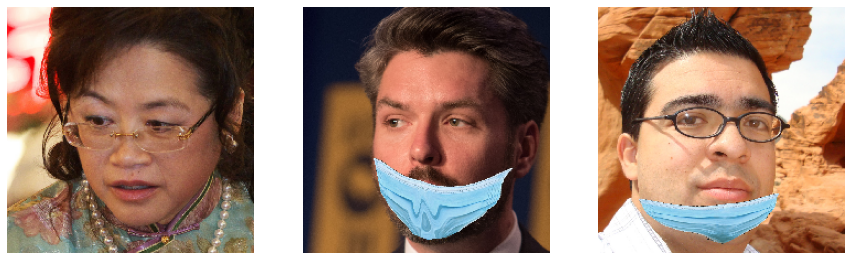

Validation samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


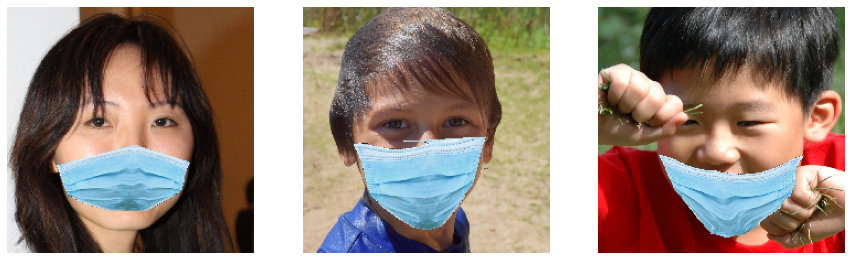

Test samples
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


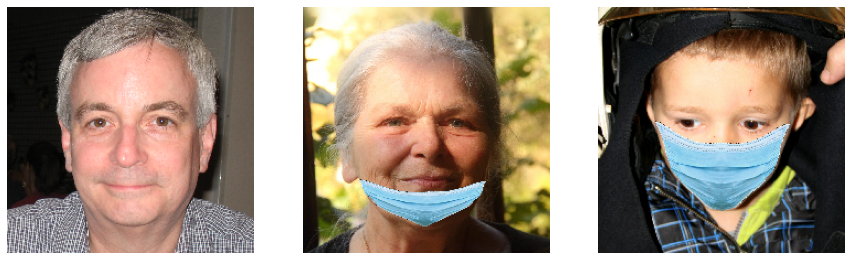

In [ ]:
# Sample some images in data generator to display

def display_samples(generator):
  '''
  Source: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
  '''
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
  for i in range(3):

    image = next(generator)[0][0]
    print(image.shape)

    ax[i].imshow(image)
    ax[i].axis('off')
  fig.show()
  plt.show()

print('Train samples')
display_samples(train_generator)
print('Validation samples')
display_samples(val_generator)
print('Test samples')
display_samples(test_generator)

## Build Model with MobileNetV3Large Scenario 1

In this scenario, we'd be retraining last 10% layers of the `MobileNetV3Large`, then add `Global Average Pooling 2D` and single `Dense` layer for output. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False
    )

last_output = mobilenet.output
last_output = tf.keras.layers.GlobalAveragePooling2D()(last_output)
# last_output = tf.keras.layers.Dense(1024, activation='relu')(last_output)
# last_output = tf.keras.layers.Dense(1024, activation='relu')(last_output)
# last_output = tf.keras.layers.Dense(512, activation='relu')(last_output)
last_output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output)

model=tf.keras.models.Model(inputs=mobilenet.input, outputs=last_output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
# Freeze MobileNet layers
len_layers = len(mobilenet.layers)
len_10_percent_layers = int(0.1*len_layers)
print(len_10_percent_layers)
for layer in mobilenet.layers[:-len_10_percent_layers]:
  layer.trainable = False

27


In [ ]:
# Iterate per layer to check trainability
is_trainables = []
for layer in model.layers:
  is_trainables.append(layer.trainable)
print(is_trainables)
print([x for x in is_trainables if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
print("Weights:", len(model.weights))
print("Trainable weights:", len(model.trainable_weights))
print("Non trainable weights:", len(model.non_trainable_weights))

Weights: 266
Trainable weights: 14
Non trainable weights: 252


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history = model.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=val_generator,
          validation_steps=steps_val,
          epochs=10,
          verbose=1)

Epoch 1/10
78/78 [==============================] - 4842s 62s/step - loss: 1.9316 - accuracy: 0.2252 - val_loss: 1.7175 - val_accuracy: 0.2010
Epoch 2/10
78/78 [==============================] - 304s 4s/step - loss: 1.5116 - accuracy: 0.3197 - val_loss: 1.7349 - val_accuracy: 0.1995
Epoch 3/10
78/78 [==============================] - 301s 4s/step - loss: 1.1555 - accuracy: 0.5380 - val_loss: 4.4107 - val_accuracy: 0.1990
Epoch 4/10
78/78 [==============================] - 302s 4s/step - loss: 0.8381 - accuracy: 0.6760 - val_loss: 4.3905 - val_accuracy: 0.1990
Epoch 5/10
78/78 [==============================] - 305s 4s/step - loss: 0.7110 - accuracy: 0.7221 - val_loss: 6.7060 - val_accuracy: 0.1964
Epoch 6/10
78/78 [==============================] - 303s 4s/step - loss: 0.6158 - accuracy: 0.7593 - val_loss: 10.8744 - val_accuracy: 0.1995
Epoch 7/10
78/78 [==============================] - 301s 4s/step - loss: 0.5196 - accuracy: 0.7986 - val_loss: 8.6079 - val_accuracy: 0.2000
Epoch 8/10

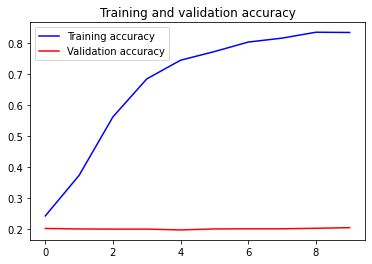

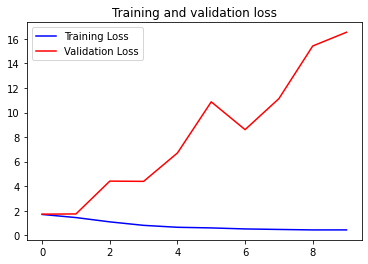

In [ ]:
# Plot accuracy of training and 'validation'
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions = list(model.predict(test_generator))
ground_truth = test_generator.classes
print(predictions)
print(ground_truth)

[array([8.517189e-13, 1.735771e-08, 7.217521e-07, 9.999993e-01,
       3.991493e-09], dtype=float32), array([3.3016949e-13, 7.7624076e-09, 2.7024163e-07, 9.9999976e-01,
       1.7877848e-09], dtype=float32), array([2.8437804e-13, 4.0274064e-09, 1.8540555e-07, 9.9999976e-01,
       1.1325747e-09], dtype=float32), array([3.4785158e-13, 5.8773373e-09, 1.9529874e-07, 9.9999976e-01,
       1.4528878e-09], dtype=float32), array([8.5655746e-14, 4.7985633e-09, 6.0262856e-08, 9.9999988e-01,
       1.3148829e-09], dtype=float32), array([1.1412465e-13, 2.1543345e-09, 8.6397172e-08, 9.9999988e-01,
       5.9357935e-10], dtype=float32), array([2.2747269e-13, 1.1874245e-08, 3.0074864e-07, 9.9999964e-01,
       2.4667217e-09], dtype=float32), array([2.8906849e-13, 1.7070624e-08, 4.2523365e-07, 9.9999952e-01,
       3.2135623e-09], dtype=float32), array([5.033272e-14, 2.701461e-09, 2.576087e-08, 1.000000e+00,
       7.618309e-10], dtype=float32), array([3.8473931e-13, 8.2862082e-09, 2.5009814e-07, 9.9

In [ ]:
lst = list()
for i in range(len(predictions)):
  lst.append(np.argmax(predictions[i]))
print(lst)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [ ]:
evaluation = model.evaluate(test_generator)
print(evaluation)

16/16 [==============================] - 45s 3s/step - loss: 16.6120 - accuracy: 0.2000
[16.612045288085938, 0.20000000298023224]


### Save Model

In [ ]:
model.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_10%_scenario_1'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_10%_scenario_1/assets


## Build Model with MobileNetV3Large Scenario 2

In this scenario, we'd be retraining last 20% layers of the `MobileNetV3Large`, then add `Global Average Pooling 2D` and single `Dense` layer for output. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet2 = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False
    )

last_output2 = mobilenet2.output
last_output2 = tf.keras.layers.GlobalAveragePooling2D()(last_output2)
# last_output2 = tf.keras.layers.Dense(1024, activation='relu')(last_output2)
# last_output2 = tf.keras.layers.Dense(1024, activation='relu')(last_output2)
# last_output2 = tf.keras.layers.Dense(512, activation='relu')(last_output2)
last_output2 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output2)

model2 = tf.keras.models.Model(inputs=mobilenet2.input, outputs=last_output2)
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
# Freeze MobileNet layers
len_layers2 = len(mobilenet2.layers)
len_20_percent_layers2 = int(0.20*len_layers2)
print(len_20_percent_layers2)
for layer in mobilenet2.layers[:-len_20_percent_layers2]:
  layer.trainable = False

55


In [ ]:
# Iterate per layer to check trainability
is_trainables2 = []
for layer in model2.layers:
  is_trainables2.append(layer.trainable)
print(is_trainables2)
print([x for x in is_trainables2 if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
print("Weights:", len(model2.weights))
print("Trainable weights:", len(model2.trainable_weights))
print("Non trainable weights:", len(model2.non_trainable_weights))

Weights: 266
Trainable weights: 30
Non trainable weights: 236


In [ ]:
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history2 = model2.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=val_generator,
          validation_steps=steps_val,
          epochs=10,
          verbose=1)

Epoch 1/10
78/78 [==============================] - 2916s 38s/step - loss: 1.7030 - accuracy: 0.2807 - val_loss: 2.1930 - val_accuracy: 0.2109
Epoch 2/10
78/78 [==============================] - 303s 4s/step - loss: 0.6605 - accuracy: 0.7311 - val_loss: 3.2629 - val_accuracy: 0.1979
Epoch 3/10
78/78 [==============================] - 308s 4s/step - loss: 0.4133 - accuracy: 0.8433 - val_loss: 5.7455 - val_accuracy: 0.2010
Epoch 4/10
78/78 [==============================] - 310s 4s/step - loss: 0.2929 - accuracy: 0.8950 - val_loss: 6.1289 - val_accuracy: 0.1995
Epoch 5/10
78/78 [==============================] - 310s 4s/step - loss: 0.2342 - accuracy: 0.9152 - val_loss: 9.2721 - val_accuracy: 0.2016
Epoch 6/10
78/78 [==============================] - 307s 4s/step - loss: 0.1879 - accuracy: 0.9328 - val_loss: 12.1196 - val_accuracy: 0.2010
Epoch 7/10
78/78 [==============================] - 309s 4s/step - loss: 0.1595 - accuracy: 0.9420 - val_loss: 15.1580 - val_accuracy: 0.2000
Epoch 8/1

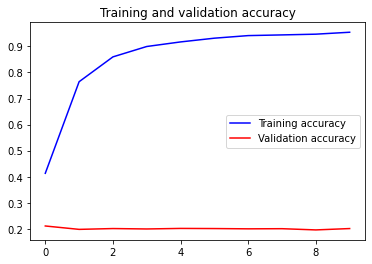

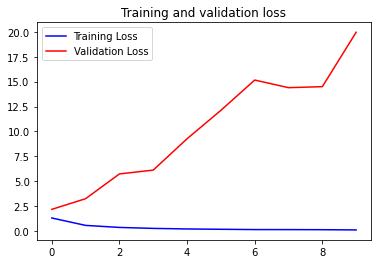

In [ ]:
# Plot accuracy of training and 'validation'
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(len(acc2))

plt.plot(epochs, acc2, 'b', label='Training accuracy')
plt.plot(epochs, val_acc2, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'b', label='Training Loss')
plt.plot(epochs, val_loss2, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions2 = list(model2.predict(test_generator))
ground_truth = test_generator.classes
print(predictions2)
print(ground_truth)

[array([6.0903180e-14, 1.0000000e+00, 4.2961387e-10, 4.7291923e-12,
       2.4270360e-08], dtype=float32), array([1.0883679e-14, 1.0000000e+00, 1.4001014e-10, 1.2538954e-12,
       1.0246263e-08], dtype=float32), array([3.5998744e-15, 1.0000000e+00, 6.2156502e-11, 6.8034901e-13,
       5.4571223e-09], dtype=float32), array([1.1671540e-14, 1.0000000e+00, 1.6072002e-10, 1.0619895e-12,
       7.2133144e-09], dtype=float32), array([1.1930013e-14, 1.0000000e+00, 1.7590775e-10, 1.1578955e-12,
       7.3192528e-09], dtype=float32), array([2.6703886e-14, 1.0000000e+00, 2.7156613e-10, 2.0418170e-12,
       1.1828249e-08], dtype=float32), array([2.5190779e-15, 1.0000000e+00, 6.0115364e-11, 3.6810179e-13,
       4.1139048e-09], dtype=float32), array([3.2399692e-15, 1.0000000e+00, 7.3519857e-11, 3.9411871e-13,
       3.7696557e-09], dtype=float32), array([4.9555760e-15, 1.0000000e+00, 9.6927640e-11, 5.6399042e-13,
       4.9275046e-09], dtype=float32), array([3.0769302e-14, 1.0000000e+00, 2.876599

In [ ]:
lst = list()
for i in range(len(predictions2)):
  lst.append(np.argmax(predictions2[i]))
print(lst)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
evaluation2 = model2.evaluate(test_generator)
print(evaluation2)

16/16 [==============================] - 45s 3s/step - loss: 19.9261 - accuracy: 0.2000
[19.92613983154297, 0.20000000298023224]


### Save Model

In [ ]:
model2.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_20%_scenario_1'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_20%_scenario_1/assets


## Build Model with MobileNetV3Large Scenario 3

In this scenario, we'd be retraining last 20% layers of the `MobileNetV3Large`, then add `Global Average Pooling 2D`, some `Dense` layers, and single `Dense` layer for output to see improvement over `Scenario 2`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet3 = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False
    )

last_output3 = mobilenet3.output
last_output3 = tf.keras.layers.GlobalAveragePooling2D()(last_output3)
last_output3 = tf.keras.layers.Dense(128, activation='relu')(last_output3)
last_output3 = tf.keras.layers.Dense(64, activation='relu')(last_output3)
last_output3 = tf.keras.layers.Dense(32, activation='relu')(last_output3)
last_output3 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output3)

model3 = tf.keras.models.Model(inputs=mobilenet3.input, outputs=last_output3)

In [ ]:
# Freeze MobileNet layers
len_layers3 = len(mobilenet3.layers)
len_20_percent_layers3 = int(0.20*len_layers3)
print(len_20_percent_layers3)
for layer in mobilenet3.layers[:-len_20_percent_layers3]:
  layer.trainable = False

55


In [ ]:
# Iterate per layer to check trainability
is_trainables3 = []
for layer in model3.layers:
  is_trainables3.append(layer.trainable)
print(is_trainables3)
print([x for x in is_trainables3 if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
print("Weights:", len(model3.weights))
print("Trainable weights:", len(model3.trainable_weights))
print("Non trainable weights:", len(model3.non_trainable_weights))

Weights: 272
Trainable weights: 36
Non trainable weights: 236


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history3 = model3.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=val_generator,
          validation_steps=steps_val,
          shuffle=True,
          epochs=10,
          verbose=1)

Epoch 1/10
78/78 [==============================] - 2914s 38s/step - loss: 1.4937 - accuracy: 0.3011 - val_loss: 1.7832 - val_accuracy: 0.1990
Epoch 2/10
78/78 [==============================] - 307s 4s/step - loss: 0.5748 - accuracy: 0.7592 - val_loss: 2.0256 - val_accuracy: 0.2005
Epoch 3/10
78/78 [==============================] - 304s 4s/step - loss: 0.3985 - accuracy: 0.8502 - val_loss: 3.4556 - val_accuracy: 0.2000
Epoch 4/10
78/78 [==============================] - 306s 4s/step - loss: 0.2726 - accuracy: 0.8996 - val_loss: 4.1661 - val_accuracy: 0.2021
Epoch 5/10
78/78 [==============================] - 301s 4s/step - loss: 0.2460 - accuracy: 0.9132 - val_loss: 3.8511 - val_accuracy: 0.1995
Epoch 6/10
78/78 [==============================] - 302s 4s/step - loss: 0.2183 - accuracy: 0.9243 - val_loss: 5.4057 - val_accuracy: 0.1974
Epoch 7/10
78/78 [==============================] - 304s 4s/step - loss: 0.1625 - accuracy: 0.9463 - val_loss: 4.7246 - val_accuracy: 0.2005
Epoch 8/10


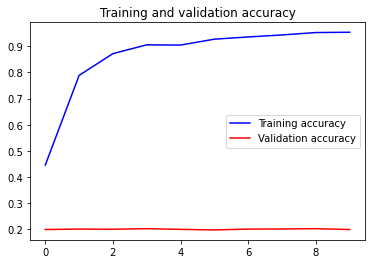

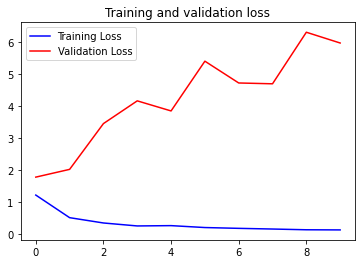

In [ ]:
# Plot accuracy of training and 'validation'
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs = range(len(acc3))

plt.plot(epochs, acc3, 'b', label='Training accuracy')
plt.plot(epochs, val_acc3, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'b', label='Training Loss')
plt.plot(epochs, val_loss3, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions3 = list(model3.predict(test_generator))
ground_truth = test_generator.classes
print(predictions3)
print(ground_truth)

[array([8.9490674e-02, 1.8781782e-05, 9.0898216e-01, 6.0427170e-05,
       1.4478662e-03], dtype=float32), array([1.23989716e-01, 2.00167924e-05, 8.74677181e-01, 6.25008106e-05,
       1.25059346e-03], dtype=float32), array([1.4799853e-01, 1.9230116e-05, 8.5070717e-01, 5.9886865e-05,
       1.2150706e-03], dtype=float32), array([6.4695068e-02, 2.1520005e-05, 9.3315834e-01, 6.5253880e-05,
       2.0598779e-03], dtype=float32), array([1.4296769e-01, 1.6390424e-05, 8.5590416e-01, 5.4066360e-05,
       1.0576341e-03], dtype=float32), array([1.3342081e-01, 1.8556451e-05, 8.6528945e-01, 6.1167033e-05,
       1.2100395e-03], dtype=float32), array([9.4160534e-02, 1.4358093e-05, 9.0476429e-01, 4.6171848e-05,
       1.0147535e-03], dtype=float32), array([2.3631756e-01, 1.6480757e-05, 7.6277220e-01, 5.0968240e-05,
       8.4271049e-04], dtype=float32), array([8.5879080e-02, 8.5160873e-06, 9.1343522e-01, 2.9802550e-05,
       6.4730964e-04], dtype=float32), array([1.2432492e-01, 2.0416564e-05, 8.7

In [ ]:
lst = list()
for i in range(len(predictions3)):
  lst.append(np.argmax(predictions3[i]))
print(lst)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
evaluation3 = model3.evaluate(test_generator)
print(evaluation3)

16/16 [==============================] - 47s 3s/step - loss: 5.9655 - accuracy: 0.2000
[5.965539455413818, 0.20000000298023224]


### Save Model

In [ ]:
model3.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_20%_scenario_3'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_20%_scenario_3/assets


## Build Model with MobileNetV3Large Scenario 4

In this scenario, we'd be retraining last 40% layers of the `MobileNetV3Large`, then add `Global Average Pooling 2D`, some `Dense` layers, and single `Dense` layer for output to see improvement over `Scenario 3`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet4 = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False
    )

last_output4 = mobilenet4.output
last_output4 = tf.keras.layers.GlobalAveragePooling2D()(last_output4)
last_output4 = tf.keras.layers.Dense(128, activation='relu')(last_output4)
last_output4 = tf.keras.layers.Dense(64, activation='relu')(last_output4)
last_output4 = tf.keras.layers.Dense(32, activation='relu')(last_output4)
last_output4 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output4)

model4 = tf.keras.models.Model(inputs=mobilenet4.input, outputs=last_output4)

17612800/17605208 [==============================] - 0s 0us/step


In [ ]:
# Freeze MobileNet layers
len_layers4 = len(mobilenet4.layers)
len_40_percent_layers4 = int(0.40*len_layers4)
print(len_40_percent_layers4)
for layer in mobilenet4.layers[:-len_40_percent_layers4]:
  layer.trainable = False

110


In [ ]:
# Iterate per layer to check trainability
is_trainables4 = []
for layer in model4.layers:
  is_trainables4.append(layer.trainable)
print(is_trainables4)
print([x for x in is_trainables4 if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
print("Weights:", len(model4.weights))
print("Trainable weights:", len(model4.trainable_weights))
print("Non trainable weights:", len(model4.non_trainable_weights))

Weights: 272
Trainable weights: 68
Non trainable weights: 204


In [ ]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

In [ ]:
model4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history4 = model4.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=val_generator,
          validation_steps=steps_val,
          shuffle=True,
          epochs=10,
          verbose=1)

Epoch 1/10
29/78 [==========>...................] - ETA: 1:50:25 - loss: 1.5913 - accuracy: 0.2476

In [ ]:
# Plot accuracy of training and 'validation'
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

epochs = range(len(acc4))

plt.plot(epochs, acc4, 'b', label='Training accuracy')
plt.plot(epochs, val_acc4, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'b', label='Training Loss')
plt.plot(epochs, val_loss4, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions4 = list(model4.predict(test_generator))
ground_truth = test_generator.classes
print(predictions4)
print(ground_truth)

In [ ]:
lst = list()
for i in range(len(predictions4)):
  lst.append(np.argmax(predictions4[i]))
print(lst)

In [ ]:
evaluation4 = model4.evaluate(test_generator)
print(evaluation4)

In [ ]:
evaluation4a = model4.evaluate(train_generator, steps=3)
evaluation4b = model4.evaluate(val_generator, steps=3)
print(evaluation4a)
print(evaluation4b)

### Save Model

In [ ]:
model4.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_40%_scenario_4'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_40%_scenario_4/assets


## Build Model with MobileNetV3Large Scenario 5

In this scenario, we'd be retraining last 20% layers of the `MobileNetV3Large`, then add `Flatten` instead of `Global Average Pooling 2D`, then some `Dense` layers, and single `Dense` layer for output to see effect to `Scenario 3`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet5 = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False
    )

last_output5 = mobilenet5.output
last_output5 = tf.keras.layers.Flatten()(last_output5)
# last_output5 = tf.keras.layers.Dense(128, activation='relu')(last_output5)
# last_output5 = tf.keras.layers.Dense(64, activation='relu')(last_output5)
last_output5 = tf.keras.layers.Dense(32, activation='relu')(last_output5)
last_output5 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output5)

model5 = tf.keras.models.Model(inputs=mobilenet5.input, outputs=last_output5)

In [ ]:
# Freeze MobileNet layers
len_layers5 = len(mobilenet5.layers)
len_20_percent_layers5 = int(0.20*len_layers5)
print(len_20_percent_layers5)
for layer in mobilenet5.layers[:-len_20_percent_layers5]:
  layer.trainable = False

55


In [ ]:
# Iterate per layer to check trainability
is_trainables5 = []
for layer in model5.layers:
  is_trainables5.append(layer.trainable)
print(is_trainables5)
print([x for x in is_trainables5 if x])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [ ]:
print("Weights:", len(model5.weights))
print("Trainable weights:", len(model5.trainable_weights))
print("Non trainable weights:", len(model5.non_trainable_weights))

Weights: 268
Trainable weights: 32
Non trainable weights: 236


In [ ]:
model5.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
____________________________________________________________________________________________

In [ ]:
model5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history5 = model5.fit(train_generator,
          steps_per_epoch=steps_train//2,
          validation_data=val_generator,
          validation_steps=steps_val,
          shuffle=True,
          epochs=10,
          verbose=1)

Epoch 1/10
39/39 [==============================] - 6720s 173s/step - loss: 8.4401 - accuracy: 0.2038 - val_loss: 1.6095 - val_accuracy: 0.1995
Epoch 2/10
39/39 [==============================] - 3213s 83s/step - loss: 1.6094 - accuracy: 0.1994 - val_loss: 1.6094 - val_accuracy: 0.2026
Epoch 3/10
39/39 [==============================] - 1525s 39s/step - loss: 1.6095 - accuracy: 0.1970 - val_loss: 1.6094 - val_accuracy: 0.1990
Epoch 4/10
39/39 [==============================] - 906s 23s/step - loss: 1.6095 - accuracy: 0.1983 - val_loss: 1.6094 - val_accuracy: 0.2021
Epoch 5/10
39/39 [==============================] - 465s 12s/step - loss: 1.6094 - accuracy: 0.1985 - val_loss: 1.6095 - val_accuracy: 0.1979
Epoch 6/10
39/39 [==============================] - 392s 10s/step - loss: 1.6094 - accuracy: 0.1987 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 7/10
39/39 [==============================] - 289s 7s/step - loss: 1.6093 - accuracy: 0.2088 - val_loss: 1.6095 - val_accuracy: 0.2005
Epo

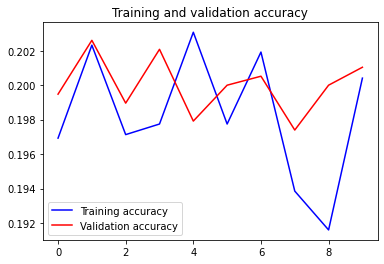

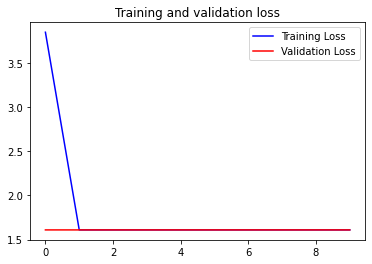

In [ ]:
# Plot accuracy of training and 'validation'
acc5 = history5.history['accuracy']
val_acc5 = history5.history['val_accuracy']
loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']

epochs = range(len(acc5))

plt.plot(epochs, acc5, 'b', label='Training accuracy')
plt.plot(epochs, val_acc5, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'b', label='Training Loss')
plt.plot(epochs, val_loss5, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions5 = list(model5.predict(test_generator))
ground_truth = test_generator.classes
print(predictions5)
print(ground_truth)

[array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.20140702, 0.19923484, 0.2021605 , 0.19995928, 0.19723836],
      dtype=float32), array([0.

In [ ]:
lst5 = list()
for i in range(len(predictions5)):
  lst5.append(np.argmax(predictions5[i]))
print(lst5)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [ ]:
evaluation5a = model5.evaluate(train_generator, steps=5)
evaluation5b = model5.evaluate(val_generator, steps=5)
evaluation5c = model5.evaluate(test_generator, steps=5)
print(evaluation5a)
print(evaluation5b)
print(evaluation5c)

5/5 [==============================] - 16s 3s/step - loss: 1.6091 - accuracy: 0.2281
[1.6098686456680298, 0.18593749403953552]
[1.6097886562347412, 0.19687500596046448]
[1.6090797185897827, 0.22812500596046448]


### Save Model

In [ ]:
model5.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_20%_scenario_5'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_20%_scenario_5/assets


## Build Model with MobileNetV3Large Scenario 6

In this scenario, we'd be retraining all layers of the `MobileNetV3Large`, then add `Global Average Pooling 2D`, and single `Dense` layer for output to see improvement over `Scenario 4`. Model would be compiled using `Categorical Crossentropy` loss, `Adam` optimizer, and `accuracy` metric.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
NUM_CLASSES = train_generator.num_classes

In [ ]:
mobilenet6 = MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
    )

last_output6 = mobilenet6.output
last_output6 = tf.keras.layers.GlobalAveragePooling2D()(last_output6)
# last_output6 = tf.keras.layers.Dense(128, activation='relu')(last_output6)
# last_output6 = tf.keras.layers.Dense(64, activation='relu')(last_output6)
# last_output6 = tf.keras.layers.Dense(32, activation='relu')(last_output6)
last_output6 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(last_output6)

model6 = tf.keras.models.Model(inputs=mobilenet6.input, outputs=last_output6)

17612800/17605208 [==============================] - 0s 0us/step


In [ ]:
# Set retrainable to all MobileNet layers
for layer in mobilenet6.layers:
  layer.trainable = True

In [ ]:
# Iterate per layer to check trainability
is_trainables6 = []
for layer in model6.layers:
  is_trainables6.append(layer.trainable)
print(is_trainables6)
print([x for x in is_trainables6 if x])

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

In [ ]:
print("Weights:", len(model6.weights))
print("Trainable weights:", len(model6.trainable_weights))
print("Non trainable weights:", len(model6.non_trainable_weights))

Weights: 266
Trainable weights: 174
Non trainable weights: 92


In [ ]:
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

In [ ]:
model6.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
steps_train = train_generator.n//BATCH_SIZE
steps_val = val_generator.n//BATCH_SIZE

history6 = model6.fit(train_generator,
          steps_per_epoch=steps_train,
          validation_data=val_generator,
          validation_steps=steps_val,
          shuffle=True,
          epochs=10,
          verbose=1)

Epoch 1/10
78/78 [==============================] - 3842s 49s/step - loss: 0.5083 - accuracy: 0.8407 - val_loss: 1.9168 - val_accuracy: 0.2021
Epoch 2/10
78/78 [==============================] - 1972s 25s/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 2.0197 - val_accuracy: 0.2016
Epoch 3/10
78/78 [==============================] - 2016s 26s/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 1.9596 - val_accuracy: 0.2031
Epoch 4/10
78/78 [==============================] - 2042s 26s/step - loss: 6.9193e-04 - accuracy: 1.0000 - val_loss: 1.9493 - val_accuracy: 0.2021
Epoch 5/10
78/78 [==============================] - 2071s 26s/step - loss: 3.5382e-04 - accuracy: 0.9998 - val_loss: 2.0512 - val_accuracy: 0.2026
Epoch 6/10
78/78 [==============================] - 2042s 26s/step - loss: 1.3698e-04 - accuracy: 1.0000 - val_loss: 2.0399 - val_accuracy: 0.1990
Epoch 7/10
78/78 [==============================] - 2047s 26s/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 3.5620 - val_accu

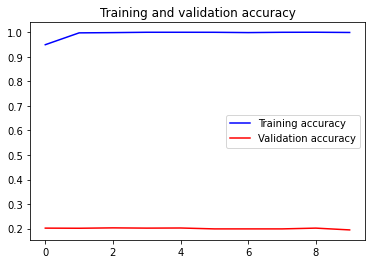

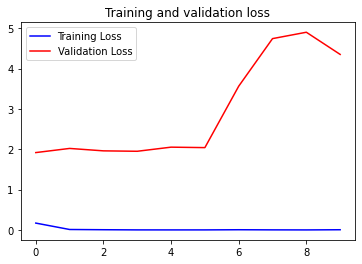

In [ ]:
# Plot accuracy of training and 'validation'
acc6 = history6.history['accuracy']
val_acc6 = history6.history['val_accuracy']
loss6 = history6.history['loss']
val_loss6 = history6.history['val_loss']

epochs = range(len(acc6))

plt.plot(epochs, acc6, 'b', label='Training accuracy')
plt.plot(epochs, val_acc6, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss6, 'b', label='Training Loss')
plt.plot(epochs, val_loss6, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluation

In [ ]:
predictions6 = list(model6.predict(test_generator))
ground_truth = test_generator.classes
print(predictions6)
print(ground_truth)

[array([0.01029273, 0.964279  , 0.00169672, 0.00132206, 0.02240958],
      dtype=float32), array([0.0115215 , 0.9606449 , 0.00181707, 0.00147523, 0.02454129],
      dtype=float32), array([0.00945925, 0.9666054 , 0.00154125, 0.0012454 , 0.02114869],
      dtype=float32), array([0.01062325, 0.9634476 , 0.00162243, 0.0013465 , 0.02296025],
      dtype=float32), array([0.01002556, 0.96573424, 0.0015571 , 0.00128589, 0.02139714],
      dtype=float32), array([0.00979696, 0.9666036 , 0.00151953, 0.00121235, 0.02086774],
      dtype=float32), array([0.00896641, 0.9680453 , 0.00136568, 0.00114017, 0.02048244],
      dtype=float32), array([0.01053843, 0.961381  , 0.00180783, 0.00134342, 0.02492937],
      dtype=float32), array([0.00974355, 0.9667066 , 0.00150328, 0.0012372 , 0.0208093 ],
      dtype=float32), array([0.00973531, 0.96690327, 0.00148927, 0.00123792, 0.02063421],
      dtype=float32), array([0.00971671, 0.96602404, 0.00157323, 0.00128849, 0.02139762],
      dtype=float32), array([0.

In [ ]:
lst = list()
for i in range(len(predictions6)):
  lst.append(np.argmax(predictions6[i]))
print(lst)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
evaluation6a = model6.evaluate(train_generator, steps=10)
evaluation6b = model6.evaluate(val_generator, steps=10)
evaluation6c = model6.evaluate(test_generator, steps=10)
print(evaluation6a)
print(evaluation6b)
print(evaluation6c)

10/10 [==============================] - 71s 7s/step - loss: 4.2776 - accuracy: 0.2070
[4.343649864196777, 0.19296875596046448]
[4.302661418914795, 0.20468750596046448]
[4.27760648727417, 0.20703125]


### Save Model

In [ ]:
model6.save(os.path.join(MODEL_DIR, 'model_mobilenetv3large_retrain_100%_scenario_6'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/capstone_machine_learning/capstone_notebooks/Models/model_mobilenetv3large_retrain_100%_scenario_6/assets
